# Position-Switched Data Reduction

This notebook shows how to use `dysh` to calibrate an OnOff observation.
It retrieves and calibrates position-switch scans using `GBTFITSLoad.getps()`, which returns a `ScanBlock` object.  OffOn observations can be reduced the same way.

In [1]:
from pathlib import Path
import astropy.units as u
from dysh.util.download import from_url
from dysh.fits.gbtfitsload import GBTFITSLoad

## Data Retrieval

Download the example SDFITS data, if necessary.

In [2]:
url = "http://www.gb.nrao.edu/dysh/example_data/positionswitch/data/AGBT05B_047_01/AGBT05B_047_01.raw.acs/AGBT05B_047_01.raw.acs.fits"
savepath = Path.cwd() / "data"
filename = from_url(url, savepath)

## Data Loading

Next, we use `GBTFITSLoad` to load the data, and then its `summary` method to inspect its contents.

In [3]:
sdfits = GBTFITSLoad(filename)

In [4]:
sdfits.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.343112,18.64274
1,52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.930571,18.787219
2,53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,199.330491,18.356075
3,54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,199.915725,18.492742
4,55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,200.304237,18.057533
5,56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,200.890603,18.186034
6,57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,202.327548,17.385267
7,58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,202.919161,17.494902


## Data Reduction

### Single Scan

Next we calibrate one scan of the position switched observations. We will start with scan 51, a single spectral window and polarization.

If you don't want to calibrate, add, `calibrate=False`.

In [5]:
ps_scan_block = sdfits.getps(scan=51, ifnum=0, plnum=0, fdnum=0)

In [6]:
print(f"T_sys = {ps_scan_block[0].tsys.mean():.2f}")

T_sys = 19.36


#### Time Averaging

To time average the contents of a `ScanBlock` use its `timeaverage` method. Be aware that time averging will not check if the source is the same. 

By default time averaging uses the following weights: 
$$
\frac{T^{2}_{sys}}{\Delta\nu\Delta t}
$$
with $T_{sys}$ the system temperature, $\Delta\nu$ the channel width and $\Delta t$ the integration time. In `dysh` these are set using `weights='tsys'` (the default).

In [7]:
ta = ps_scan_block.timeaverage(weights='tsys')

#### Plotting

Plot the data and use different units for the spectral axis.

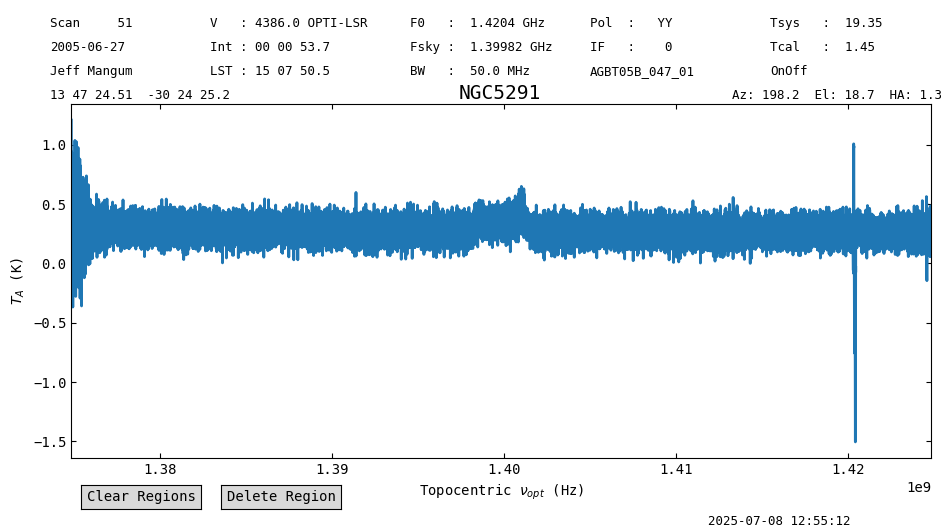

In [8]:
ta.plot()

Change the spectral axis units to km/s and the y-axis to mK, while also showing the spectra between 3600 and 5300 km/s, with the y-axis range between -100 and 1000 mK.

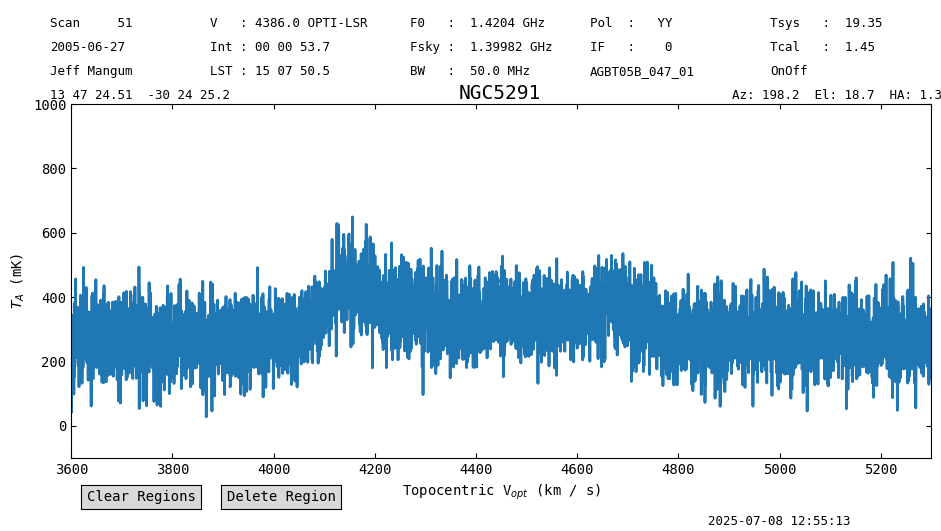

In [9]:
ta.plot(xaxis_unit="km/s", yaxis_unit="mK", ymin=-100, ymax=1000, xmin=3600, xmax=5300)

Switch back to GHz as the spectral axis unit.

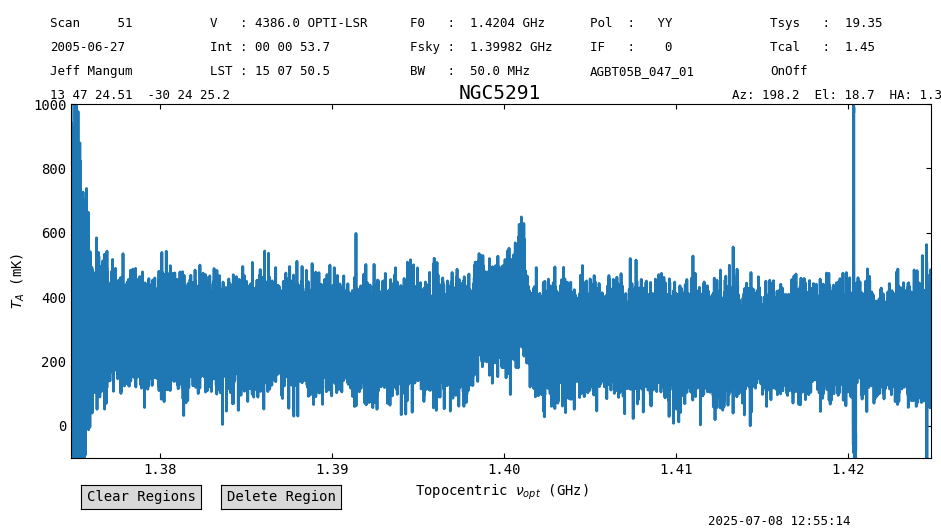

In [10]:
ta.plot(xaxis_unit="GHz", ymin=-100, ymax=1000, yaxis_unit="mK")

#### Baseline Subtraction
The following code cells show how to subtract a polynomial baseline from the data. This example uses an order 2 polynomial, and excludes the regions between 3800 and 5000 km/s, where a line is detected. The use of `remove=True` will remove the best fit baseline model from the spectrum.


For a polynomial model one may need to normalize the frequency axis in channel space using `normalize=True`, to prevent poorly conditioned fits, but this will not allow you to undo the fit.

In [11]:
kms = u.km/u.s
ta.baseline(model="poly", degree=2, exclude=[3800*kms,5000*kms], remove=True)

When we plot the spectrum again, it has been baseline subtracted.

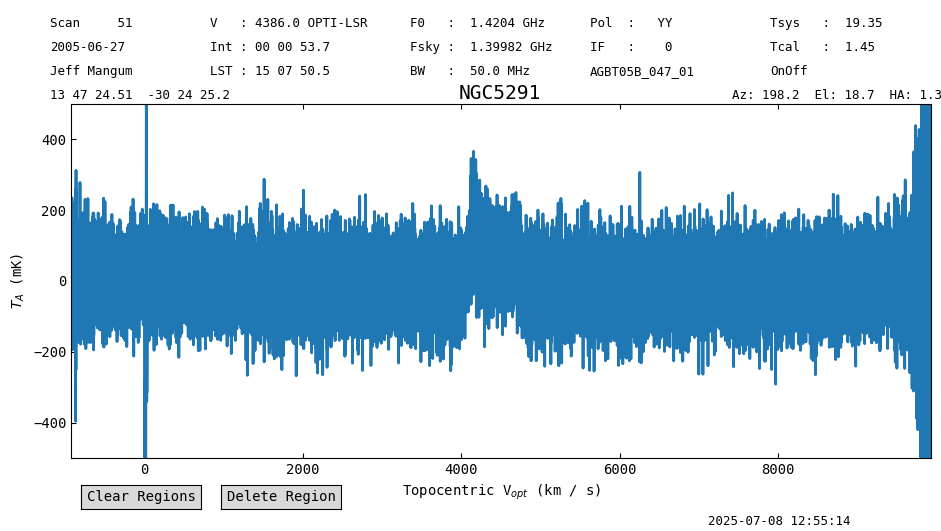

In [12]:
ta_plt = ta.plot(xaxis_unit="km/s", yaxis_unit="mK", ymin=-500, ymax=500)

We can inspect the best fit baseline coefficients.

In [13]:
print(ta.baseline_model)

<QuantityModel Polynomial1D(2, c0=0.28392721, c1=0.02442757, c2=-0.00964561, domain=(1424816838.1210938, 1374818364.0)), input_units=Hz, return_units=K>


And save the figure.

In [14]:
output_dir = Path.cwd() / "output"
ta_plt.savefig(output_dir / "baselined_removed.png")

---

#### Using Selection

The following code shows how to calibrate scan 51 using selection. At this time selection does not know about signal and reference scan pairs, so the selection must include both scans, otherwise the calibration will fail.

In [15]:
sdfits.select(scan=[51,52])
sdfits.selection.show()

 ID    TAG      SCAN  # SELECTED
--- --------- ------- ----------
  0 0fa42056c [51,52]         88


In [16]:
sb = sdfits.getps(plnum=0, ifnum=0, fdnum=0)

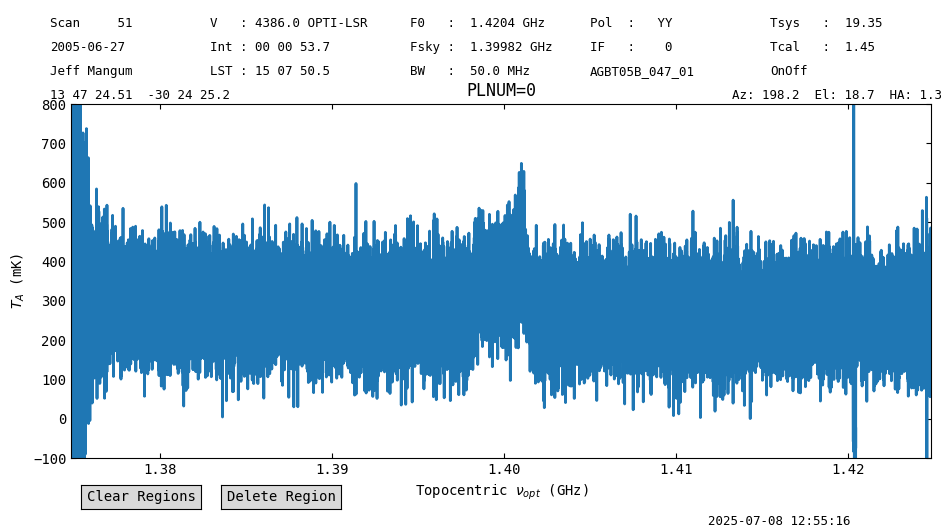

In [17]:
ta2 = sb.timeaverage(weights='tsys')
ta2.plot(xaxis_unit="GHz", ymin=-100, ymax=800, yaxis_unit="mK", title="PLNUM=0")

We can calibrate the other polarization, with the scan numbers already selected.

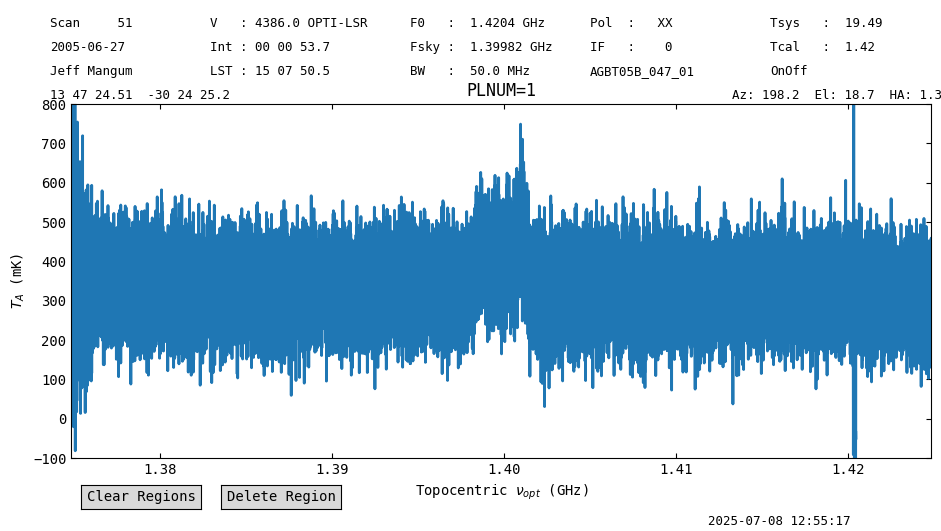

In [18]:
sb = sdfits.getps(plnum=1, fdnum=0, ifnum=0)
ta3 = sb.timeaverage(weights='tsys')
ta3.plot(xaxis_unit="GHz", ymin=-100, ymax=800, yaxis_unit="mK", title="PLNUM=1")

#### Polarization Average
Average the polarizations and plot the result.

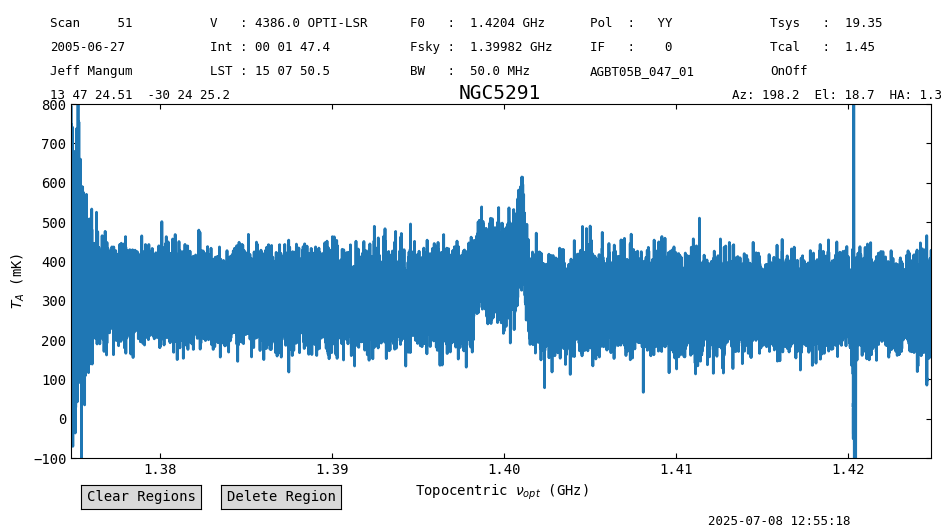

In [19]:
avg = ta2 + ta3
avg *= 0.5
avg.plot(ymin=-100, ymax=800, yaxis_unit="mK", xaxis_unit="GHz")

### All Scans

Now we leverage the power of `dysh` to calibrate and time average all of the scans in the data.

We start by clearing the selection, so all of the scans are available.

In [20]:
sdfits.selection.clear()

Then, make a `ScanBlock` for spectral window 0 and polarization 0. Time average the scans in the `ScanBlock` into a single `Spectrum` and then remove a baseline.

In [21]:
ps_scan_block_0 = sdfits.getps(ifnum=0, plnum=0, fdnum=0)
ps_ta_0 = ps_scan_block_0.timeaverage(weights='tsys')
ps_ta_0.baseline(model="poly", degree=2, exclude=[3800*kms,5000*kms], remove=True)

Now plot and compare with the result for a single scan.

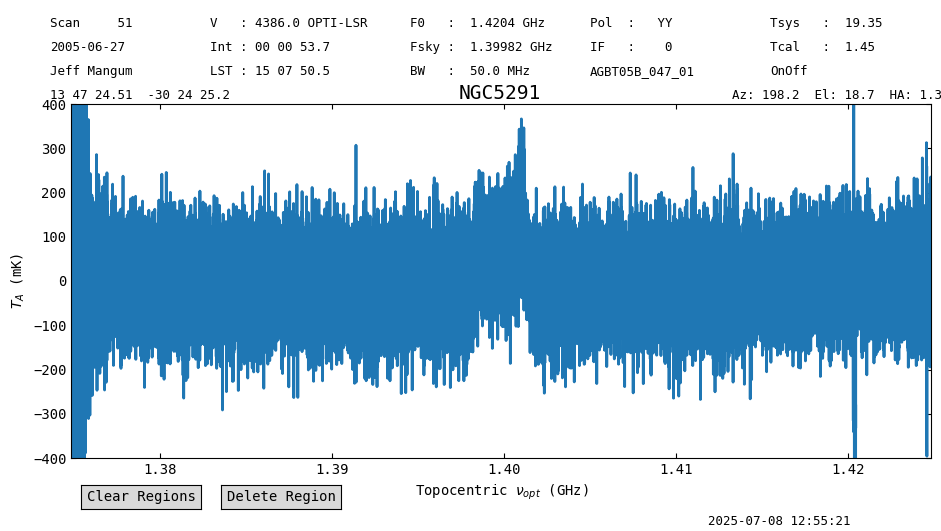

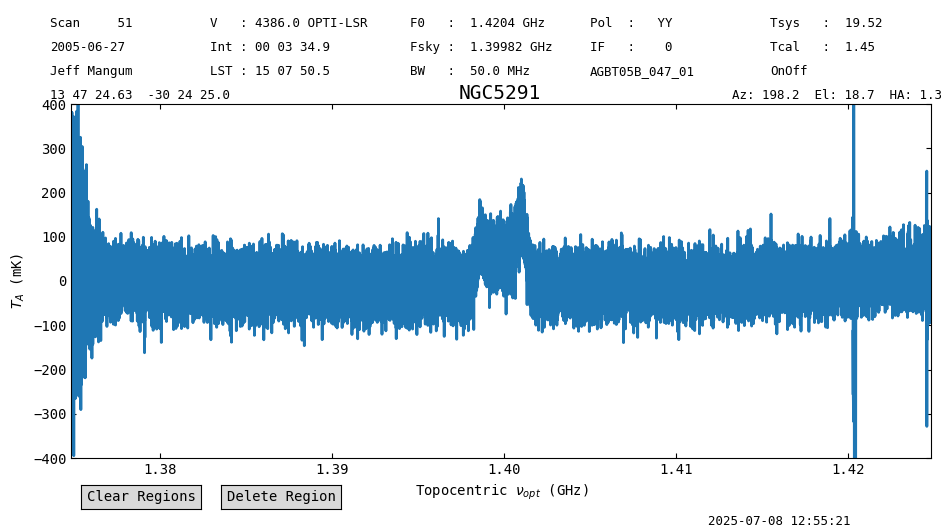

In [22]:
ta.plot(ymin=-400, ymax=400, yaxis_unit="mK", xaxis_unit="GHz")
ps_ta_0.plot(ymin=-400, ymax=400, yaxis_unit="mK", xaxis_unit="GHz")

The rms in the second Figure is almost half that of the first Figure. That is because there are four pairs of position switched scans in the data, so that results in a factor of $\sqrt{4}$ reduced noise when we average all the data.